In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
base_path = '/Users/freezylex/Documents/course_work'
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import mean_absolute_error as mae
warnings.filterwarnings('ignore')

# Target

In [2]:
target_path = 'data/final_target.xlsx'
target = pd.read_excel(os.path.join(base_path, target_path), index_col = 'Date',
                       parse_dates=True)
target.drop(columns=['SU26217RMFS', 'SU26218RMFS'], inplace=True)
target.head(2)

,SU26214RMFS,SU26215RMFS,SU26216RMFS,SU26203RMFS,SU26204RMFS,SU26205RMFS,SU26206RMFS,SU26207RMFS,SU26208RMFS,SU26209RMFS,SU26210RMFS,SU26211RMFS,SU26212RMFS
Date,,,,,,,,,,,,,
2015-03-02,-71.009402,-16.198293,-51.672678,213.214039,8.877833,-69.514138,81.363229,81.611366,-44.294101,-46.555882,-65.581271,-32.632524,103.025743
2015-03-03,7.255880,45.041981,17.967756,263.188637,62.406383,10.363783,125.481830,112.795674,22.874165,26.012453,9.625523,34.752162,129.932953


# Metrics

In [3]:
metric_path = os.path.join(base_path, 'data/metrics_final')

rvi = pd.read_csv(os.path.join(metric_path, 'rvi.csv'), index_col = 'Date', parse_dates = True).loc['2015-06-01':]
cds = pd.read_csv(os.path.join(metric_path, 'cds.csv'), index_col = 'Date', parse_dates = True).loc['2015-06-01':]
#usdrub = pd.read_csv(os.path.join(metric_path, 'usdrub.csv'), index_col = 'Date', parse_dates = True).loc['2015-06-01':]
BA = pd.read_csv(os.path.join(metric_path, 'BA.csv'), index_col = 'Date', parse_dates = True)
TC = pd.read_csv(os.path.join(metric_path, 'TC.csv'), index_col = 'Date', parse_dates = True)
PD = pd.read_csv(os.path.join(metric_path, 'PD.csv'), index_col = 'Date', parse_dates = True)
TR = pd.read_excel(os.path.join(metric_path, 'till_redemption.xlsx'), index_col = 'Date', parse_dates = True)
curve = pd.read_csv(os.path.join(metric_path, 'PCA_curve.csv'), index_col = 'Date', parse_dates = True)

# Join

In [4]:
available_indexes = list((set(rvi.index) & set(cds.index) & \
                          set(BA.index) & set(target.index)))
available_indexes = np.sort(np.array(available_indexes))

In [5]:
len(available_indexes)

178

In [6]:
target = target.loc[available_indexes]

rvi = rvi.loc[available_indexes]
cds = cds.loc[available_indexes]
#usdrub = usdrub.loc[available_indexes]
BA = BA.loc[available_indexes]
TC = TC.loc[available_indexes]
PD = PD.loc[available_indexes]
TR = TR.loc[available_indexes]
curve = curve.loc[available_indexes]

In [7]:
def make_dataset_for_bond(bond_name):
    complete_data = pd.DataFrame(columns = ['log_PD', 'log_BA', 'log_TC', 
                                            'TR', 'RVI', 'CDS',
                                            'level', 'slope','curvature','target'],
                                index = target.index)
    complete_data['log_BA'] = BA[bond_name]
    complete_data['LT_BA'] = BA[f"{bond_name}_low_trading_dummy"]
    
    complete_data['log_PD'] = PD[bond_name]
    complete_data['LT_PD'] = PD[f"{bond_name}_low_trading_dummy"]
    
    complete_data['log_TC'] = TC[bond_name]
    complete_data['LT_TC'] = TC[f"{bond_name}_low_trading_dummy"]
    
    complete_data['RVI'] = rvi['RVI']
    complete_data['RVI_struct_coef'] = rvi['struct_coef']
    complete_data['dummy_struct_Jan'] = rvi['dummy_struct_change']
    
    complete_data['CDS_dummy'] = cds['CDS_dummy_struct']
    complete_data['CDS'] = cds['CDS1Y']
    complete_data['CDS_new_slope'] = cds['CDS_struct_coef']
    
    #complete_data['USDRUB'] = usdrub['USDRUB_CBR']
    #complete_data['oil_shock_1st_USDRUB_dummy'] = usdrub['dummy_1_oil_shock']
    #complete_data['oil_shock_1st_USDRUB_coef'] = usdrub['USDcoef_oil_shock_1']
    
    complete_data['TR'] = TR[bond_name]
    complete_data['target'] = target[bond_name]
    
    complete_data['level'] = curve['level']
    complete_data['slope'] = curve['slope']
    complete_data['curvature'] = curve['curvature']
    
    return complete_data

# Build model

In [8]:
def make_model(train_sample, test_sample, factors, target_field, return_resids = None):
    model = OLS(train_sample[target_field], train_sample[factors]).fit()
    if return_resids:
        predictions_test = model.predict(test_sample[factors])
        resids_test = test_sample[target_field] - predictions_test
        resids_train = model.resid
        return resids_train, resids_test
    else:
        predictions_train = model.predict()
        predictions_test = model.predict(test_sample[factors])
        mae_train = mae(train_sample[target_field], predictions_train)
        mae_test = mae(test_sample[target_field], predictions_test)
        return model, mae_train, mae_test

In [13]:
def make_info(bond_name):
    sample = make_dataset_for_bond(bond_name)
    sample = sample.diff().dropna(axis='rows')
    sample['const'] = 1
    sample_train, sample_test = sample.loc[:'2016-01-29'], sample.loc['2016-02':]
    print(sample_test.shape)
    #### Variables definition ##########
    liquidity_vars = ['log_PD','RVI','log_TC'] #level #RVI 
    credit_risk_factors = ['CDS', 'curvature'] #curvature
    #### Models ########
    ## All variables
    all_vars = liquidity_vars + credit_risk_factors
    #sample_train[all_vars + ['target']].to_excel(os.path.join(base_path, 
    #                                                          f'files_for_stata/{bond_name}.xlsx')) #For stata
    model_all, mae_train_all, mae_test_all = make_model(sample_train, sample_test, all_vars, 'target')
    ## Only credit risk factors ####
    model_credit, mae_train_credit, mae_test_credit = make_model(sample_train, sample_test,
                                                                 credit_risk_factors, 'target')
    ## liquidity influence after extracting credit risk factors ###
    #resids_tr, resids_ts = make_model(sample_train, sample_test, 
    #                                  credit_risk_factors, 'target', return_resids = True)
    #sample_train['residuals'] = resids_tr
    #sample_test['residuals'] = resids_ts
    #model_liq, mae_train_liq, mae_test_liq = make_model(sample_train, sample_test,
    #                                                             liquidity_vars, 'residuals')
    ##### Liquidity model ###########
    model_liq, mae_train_liq, mae_test_liq = make_model(sample_train, sample_test,
                                                                 liquidity_vars, 'target')
    summary_table = pd.DataFrame(index = ['train', 'test'], 
                                 columns = ['All variables', 
                                            'Credit Risk Factors', 
                                            'Liquidity factors']) #Pure liquidity Factors influence
    summary_table.loc['train', 'All variables'] = mae_train_all
    summary_table.loc['test', 'All variables'] = mae_test_all 
    
    summary_table.loc['train', 'Credit Risk Factors'] = mae_train_credit
    summary_table.loc['test', 'Credit Risk Factors'] = mae_test_credit
    
    summary_table.loc['train', 'Liquidity factors'] = mae_train_liq
    summary_table.loc['test', 'Liquidity factors'] = mae_test_liq
    return summary_table, model_all, model_credit, model_liq, sample[all_vars + ['target']].corr() 
    

In [14]:
table, all_, credit, liq, corr_factors = make_info('SU26214RMFS')

(15, 18)


In [15]:
table

,All variables,Credit Risk Factors,Liquidity factors
train,8.640905,8.962793,9.116812
test,6.815201,7.235804,6.552055


In [16]:
all_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 target   R-squared (uncentered):                   0.254
Model:                            OLS   Adj. R-squared (uncentered):              0.230
Method:                 Least Squares   F-statistic:                              10.67
Date:                Wed, 27 Apr 2022   Prob (F-statistic):                    7.65e-09
Time:                        23:40:05   Log-Likelihood:                         -618.53
No. Observations:                 162   AIC:                                      1247.
Df Residuals:                     157   BIC:                                      1263.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
log_PD         0.3143      0.554      0.567      0.572      -0.781       1.410
RVI           -1.6847      0.410     -4.105      0.000      -2.495      -0.874
log_TC        -0.4852      0.897     -0.541      0.589      -2.257       1.286
CDS           -0.2422      0.097     -2.501      0.013      -0.434      -0.051
curvature      0.1198      0.037      3.216      0.002       0.046       0.193
==============================================================================
Omnibus:                        1.017   Durbin-Watson:                   2.333
Prob(Omnibus):                  0.601   Jarque-Bera (JB):                0.641
Skew:                          -0.029   Prob(JB):                        0.726
Kurtosis:                       3.303   Cond. No.                         26.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
(credit).rsquared_adj #здесь коэффициенты очевидно смещены и несостоятельны. Поэтому стоит смотреть только на r^2

0.06359706173849489

In [46]:
credit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 target   R-squared (uncentered):                   0.069
Model:                            OLS   Adj. R-squared (uncentered):              0.064
Method:                 Least Squares   F-statistic:                              12.00
Date:                Wed, 27 Apr 2022   Prob (F-statistic):                    0.000681
Time:                        01:27:20   Log-Likelihood:                         -709.19
No. Observations:                 162   AIC:                                      1420.
Df Residuals:                     161   BIC:                                      1423.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CDS           -0.5296      0.153     -3.464      0.001      -0.831      -0.228
==============================================================================
Omnibus:                       19.161   Durbin-Watson:                   2.356
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.023
Skew:                          -0.466   Prob(JB):                     1.67e-10
Kurtosis:                       5.408   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
liq.rsquared_adj

-0.008279700868260464

In [34]:
liq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 target   R-squared (uncentered):                   0.010
Model:                            OLS   Adj. R-squared (uncentered):             -0.008
Method:                 Least Squares   F-statistic:                             0.5566
Date:                Wed, 27 Apr 2022   Prob (F-statistic):                       0.644
Time:                        01:21:44   Log-Likelihood:                         -714.17
No. Observations:                 162   AIC:                                      1434.
Df Residuals:                     159   BIC:                                      1444.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
log_PD         0.8994      1.495      0.601      0.548      -2.054       3.853
RVI           -0.8581      0.709     -1.210      0.228      -2.258       0.542
log_TC        -0.9599      2.373     -0.405      0.686      -5.646       3.726
==============================================================================
Omnibus:                       19.659   Durbin-Watson:                   2.428
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.908
Skew:                          -0.476   Prob(JB):                     6.52e-11
Kurtosis:                       5.458   Cond. No.                         3.46
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [140]:
corr_factors

,log_PD,RVI,level,log_TC,CDS,curvature,target
log_PD,1.000000,-0.139065,0.046188,-0.198214,0.066130,-0.053838,0.062198
RVI,-0.139065,1.000000,0.424584,-0.054068,0.301556,-0.065615,-0.381601
level,0.046188,0.424584,1.000000,-0.040473,0.486395,-0.652666,-0.733345
log_TC,-0.198214,-0.054068,-0.040473,1.000000,-0.163241,-0.057103,-0.022558
CDS,0.066130,0.301556,0.486395,-0.163241,1.000000,-0.233223,-0.320118
curvature,-0.053838,-0.065615,-0.652666,-0.057103,-0.233223,1.000000,0.292300
target,0.062198,-0.381601,-0.733345,-0.022558,-0.320118,0.292300,1.000000


In [141]:
corr_factors.to_excel(os.path.join(base_path, 'stats/26214_corr.xlsx'))

In [24]:
df = make_dataset_for_bond('SU26214RMFS')
df = df.diff().dropna(axis='rows')
df = df.drop(columns = ['RVI_struct_coef',
                       'dummy_struct_Jan', 'CDS_new_slope', 'CDS_dummy', 'LT_TC', 'LT_PD', 'LT_BA', 'TR',
                       'log_BA', 'slope']) #slope

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

pd.Series([variance_inflation_factor(df.values, i) 
               for i in range(df.shape[1])], 
              index=df.columns).sort_values()

log_TC       1.088749
log_PD       1.096758
CDS          1.389262
RVI          1.403653
curvature    2.262469
target       2.589985
level        5.309002
dtype: float64

In [175]:
df.corr().to_excel(os.path.join(base_path, 'stats/26214_corr.xlsx'))

<AxesSubplot:xlabel='curvature', ylabel='target'>

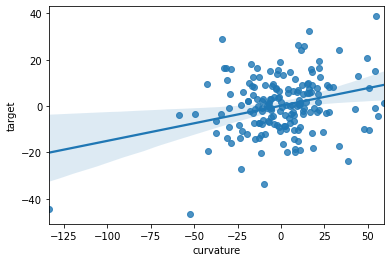

In [26]:
sns.regplot(x = df['curvature'], y = df['target'])

<AxesSubplot:xlabel='Date', ylabel='target'>

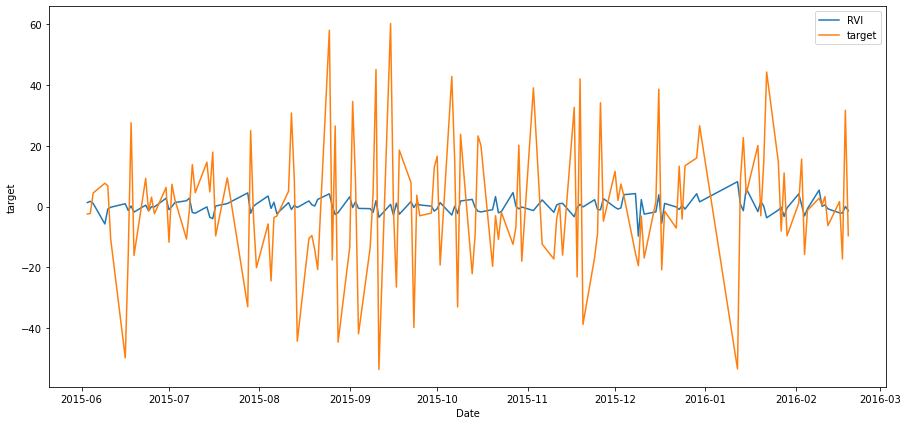

In [221]:
fig, ax = plt.subplots(figsize=(15,7))
sns.lineplot(x = df['RVI'].index, y = df['RVI'].values, label='RVI')
sns.lineplot(data = df['target'], label='target')

<AxesSubplot:xlabel='Date'>

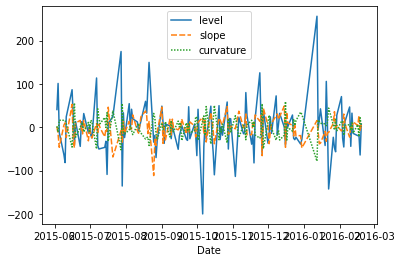

In [173]:
sns.lineplot(data = curve.diff())